This is a demonstration of the power of source-filter theory. We will be performing a rather crude (but not necessarily simple) synthesis of four vowels: [ə], [i], [u], and [ɑ] for both male and female speakers. The synthesis is crude in the sense that it makes use of idealized behavior of the vocal tract and does not use a particularly human-sounding source.

In [1]:
using DSP
using Plots
using WAV
using Statistics

We will first need a function that will create the filter. You do not need to concern yourself with the mathematical particulars of the filter, and you can just trust that it will work. If you would like more details, though, read the following article:

Klatt, D. H. (1980). Software for a cascade/parallel formant synthesizer. *The Journal of the Acoustical Society of America, 67*(3), 971-995.

In [2]:
function make_filter(cf, bw, T)
    R = exp(-π * bw * T)
    C = -exp(-2π * bw * T)
    B = 2* exp(-π * bw * T) * cos(2π * cf * T)
    A = 1 - B - C
    filtf1 = Biquad(1., 0., 0., -2R*cos(2π*cf*T), R^2)
    Biquad(A, 0., 0., -B, -C)
end

make_filter (generic function with 1 method)

Next, we will need a function that will calculate the combined frequency response is of the resonant filters we will be applying to the speech source. This function will allow for the display of individual resonant filters as well, so long as the central frequency is still in an `Array`.

* **res** The central *resonant* frequencies for each formant filter
* **bw** The bandwidth of each of the resonant filters
* **fs** The sampling frequency of the incoming sound source; used for unit conversions and standardization

In [3]:
function combined_response(res::Array; bw=50, fs=16000)
    T = 1 / fs
    filts = [make_filter(r, bw, T) for r in res]
    resp1, w = freqresp(filts[1])
    resps = [[resp1]; [freqresp(filts[i])[1] for i in 2:length(filts)]]
    amp = [20*log10(prod(abs.(r))) for r in zip(resps...)]
    hz = w ./ T ./ 2π
    return hz, amp
end

combined_response (generic function with 1 method)

Finally, we will need a function that will actually synthesize the vowel we are interested in. This function will generate the resonant filters and then apply them to the a sawtooth wave.

* **res** The central *resonant* frequencies for each formant filter
* **dur** The *duration* of the synthesized vowel, in seconds
* **f0** The fundamental frequency of the generated sawtooth wave and resultant synthetic vowel
* **bw** The bandwidth of each of the resonant filters
* **fs** The sampling frequency of the incoming sound source; used for unit conversions and standardization

In [4]:
function synthesize_vowel(res::Array; dur=2, f0=120, bw=50, fs=16000)
    T = 1 / fs
    filts = [make_filter(r, bw, T) for r in res]
    t = 0:T:dur
    sawtooth_wave = f0 .* t .- floor.(f0 .* t)
    out = sawtooth_wave
    for f in filts
        out = filt(f, out)
    end
    out = out ./ maximum(abs.(out))
    return out
end

synthesize_vowel (generic function with 1 method)

Let's start by synthesizing two sawtooth waves. One will be a crude approximation of the sound a male speaker's vocal folds make. The other will be a crude approximation of the sound a female speaker's vocal folds make.

In [5]:
t = 0:1/16000:2
sawtooth_m = 120 .* t .- floor.(120 .* t);
sawtooth_f = 220 .* t .- floor.(220 .* t);

Let's see what these look like.

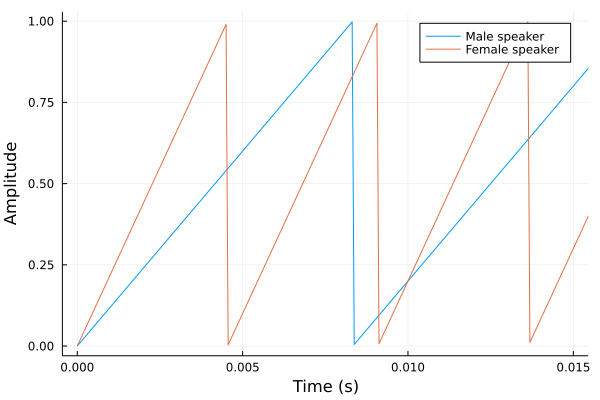

In [6]:
plot(t, sawtooth_m, xlim=[0, 2*120/16000], label="Male speaker", xlab="Time (s)", ylab="Amplitude")
plot!(t, sawtooth_f, label="Female speaker")

Let's listen to both of them.

In [7]:
wavplay(sawtooth_m, 16000)
wavplay(sawtooth_f, 16000)

That's not very pleasant! But it does model the action of the vocal folds. After the air moving through them pushes them open, they slam shut due to the Bernoulli effect. This motion is modeled by the wave gradually increading in amplitude (representing the opening of the vocal folds) and then immediately dropping down to zero (representing the rapid closure of the vocal folds).

Anyway, let's start by plotting the response for an unpertrubed tube, which will generated a [ə]-like sound. The resonant frequencies are predicted by the following formula:

$$Fn = \frac{(n+1)c}{4L}\,,$$

where $n$ is the formant that you want, $c$ is the speed of light approximated as 35,000 cm/s, and $L$ is the length in cm of the tube that the formant value is being calculated for. The average vocal tract length for males is approximately 17 cm, and it is approximately 14 cm for females. If we calculate formants 1 through 4, we get the formant values used in making the filter response plot below.

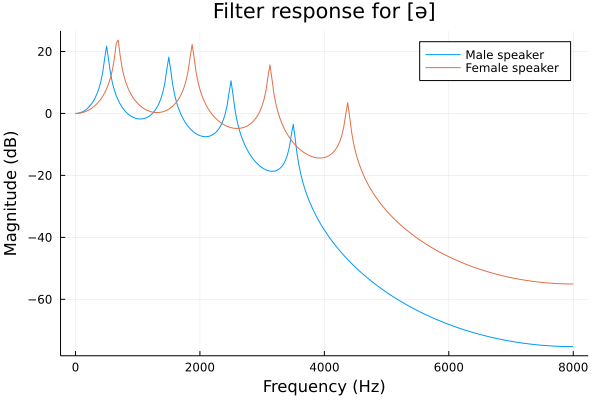

In [8]:
m_ə = [500, 1500, 2500, 3500]
plot(combined_response(m_ə)...,
    title="Filter response for [ə]",
    xlab="Frequency (Hz)",
    ylab="Magnitude (dB)",
    label="Male speaker")

f_ə = [675, 1875, 3125, 4375]
plot!(combined_response(f_ə)...,
    label="Female speaker")

Notice how there is an equal amount of spacing between each formant for each speaker. Notice as well that the female speaker values are more spread apart, which is owed to the different vocal tract length.

Let's now synthesize vowels using the above filters and see what they sound like. Each cell with audio will first play the sawtooth wave that is being used as the source, and then it will play each successive filtering of the sound. The overall sequence is

1. Sawtooth wave
2. $F1$
3. $F1$ and $F2$
4. $F1$, $F2$, and $F3$
5. $F1$, $F2$, $F3$, and $F4$

Notice how the vowel quality is mostly discernible after the addition of $F2$, and adding $F3$ and $F4$ mostly seem to add naturalness to the synthesis.

In [9]:
wavplay(sawtooth_m, 16000)
for i in 1:length(m_ə)
    wavplay(synthesize_vowel(m_ə[1:i], f0=120), 16000)
end

In [10]:
wavplay(sawtooth_f, 16000)
for i in 1:length(f_ə)
    wavplay(synthesize_vowel(f_ə[1:i], f0=220), 16000)
end

You may have noticed that did not sound exactly like the English [ə], and that's because it isn't the same. This is a true neutral vowel, and the English [ə] is not actually in the dead center of the vowel space.

Let's now see a filter respone for the [i] vowel. Note how $F1$ and $F2$ are far apart. Deriving the predicted values for the formants is more involved than for the unperturbed tube, so we will just use $F1$ and $F2$ values that come from the following project:

Hillenbrand, J., Getty, L. A., Clark, M. J., & Wheeler, K. (1995). Acoustic characteristics of American English vowels. *The Journal of the Acoustical society of America, 97*(5), 3099-3111.

We will hold $F3$ and $F4$ constant for the rest of the vowels since they are not strictly needed for quality distinctions.

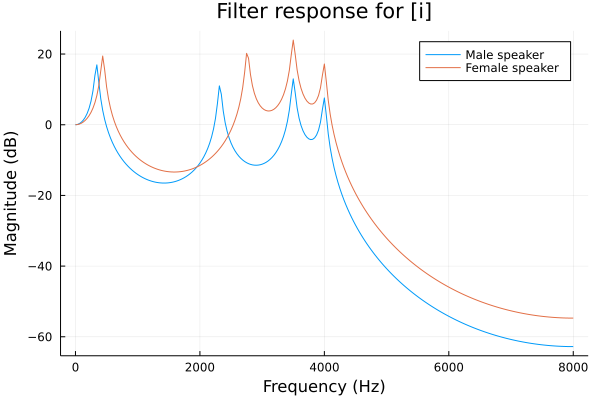

In [11]:
m_i = [340, 2320, 3500, 4000]
plot(combined_response(m_i)...,
    title="Filter response for [i]",
    xlab="Frequency (Hz)",
    ylab="Magnitude (dB)",
    label="Male speaker")

f_i = [440, 2760, 3500, 4000]
plot!(combined_response(f_i)..., label="Female speaker")

Let's see how they sound again:

In [12]:
wavplay(sawtooth_m, 16000)
for i in 1:length(m_i)
    wavplay(synthesize_vowel(m_i[1:i], f0=120), 16000)
end

In [13]:
wavplay(sawtooth_f, 16000)
for i in 1:length(m_i)
    wavplay(synthesize_vowel(f_i[1:i], f0=220), 16000)
end

Let's now look at a filter for [u]. Notice how $F1$ is relatively similar to that of [i], while the $F2$ is significantly lower.

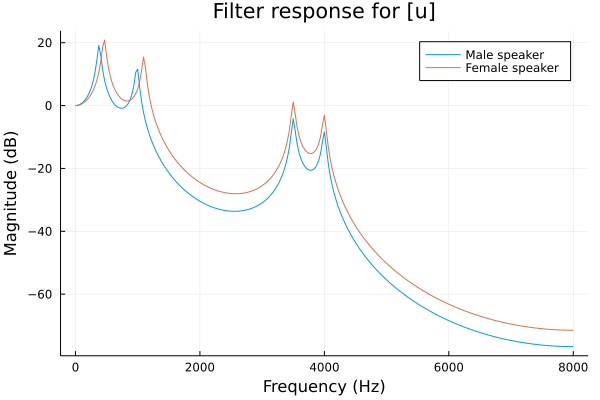

In [14]:
m_u = [380, 990, 3500, 4000]
plot(combined_response(m_u)...,
    title="Filter response for [u]",
    xlab="Frequency (Hz)",
    ylab="Magnitude (dB)",
    label="Male speaker")

f_u = [460, 1100, 3500, 4000]
plot!(combined_response(f_u)...,
    label="Female speaker")

Let's give them a listen.

In [15]:
wavplay(sawtooth_m, 16000)
for i in 1:length(m_u)
    wavplay(synthesize_vowel(m_u[1:i], f0=120), 16000)
end

In [16]:
wavplay(sawtooth_f, 16000)
for i in 1:length(f_u)
    wavplay(synthesize_vowel(f_u[1:i], f0=220), 16000)
end

Finally, let's look at a filter for [ɑ]. Note now how $F1$ and $F2$ are much closer together than they were for [i] and [u].

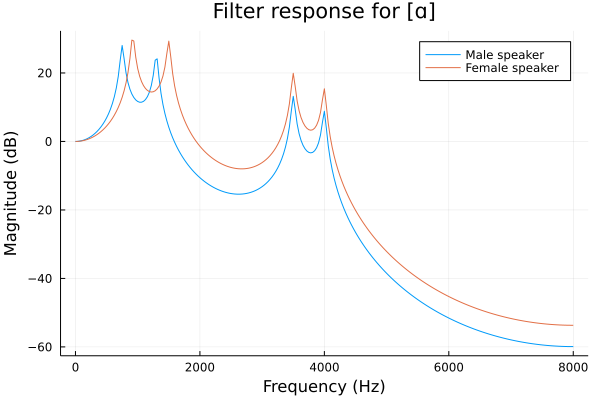

In [17]:
m_ɑ = [750, 1300, 3500, 4000]
plot(combined_response(m_ɑ)...,
    title="Filter response for [ɑ]",
    xlab="Frequency (Hz)",
    ylab="Magnitude (dB)",
    label="Male speaker")

f_ɑ = [920, 1500, 3500, 4000]
plot!(combined_response(f_ɑ)...,
    label="Female speaker")

Let's listen to these last two examples.

In [18]:
wavplay(sawtooth_m, 16000)
for i in 1:length(m_ɑ)
    wavplay(synthesize_vowel(m_ɑ[1:i], f0=120), 16000)
end

In [19]:
wavplay(sawtooth_f, 16000)
for i in 1:length(f_ɑ)
    wavplay(synthesize_vowel(f_ɑ[1:i], f0=220), 16000)
end

There are, of course, shortcomings to the crude syntheses here such as the static nature of the vowels and the selected $f0$ values. And, we have not demonstrated how consonants would be handled with this kind of approach. However, we can demonstrably show how vowel sounds can be modeled with source-filter synthesis, and I hope you are now convinced that souce-filter theory is a powerful model of human speech.